In [303]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [304]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


# Get Data

In [305]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [306]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

## Lab Data

In [307]:
labdf = PLT.get_lab_samples('https://docs.google.com/spreadsheets/d/17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U/edit#gid=0.', 'Sheet1')

# Prophet

Documentation is available [here](https://facebook.github.io/prophet/docs/quick_start.html#python-api). The associated publication for this software is [Taylor, S. J. & Letham, B., 2018. Forecasting at scale, The American Statistician, 72(1), 37–45.](https://www.tandfonline.com/doi/full/10.1080/00031305.2017.1380080?casa_token=tnhGKYTQIIYAAAAA%3AvaObcD-ZD_S8Ld-XhxryUePRNsDLlcaSCpIlhPycdRN_HLddkcSFGL00UJW-0SnpVlgJj9BToQxC)

## Installation to Anaconda

Install Prophet using `conda` took too long: 
```
conda install -c conda-forge prophet
```

So what I did is I activated my conda environment (i.e. `conda activate your_environment`) and then installed using `pip`:

```
python -m pip install prophet
```

In [308]:
# Prophet package
from prophet import Prophet

Below are some functions I directly copied from the [Prophet Github](https://github.com/facebook/prophet/blob/main/python/prophet/plot.py). These specifically should help with plotting daily seasonalities. I don't understand why simply importing the package doesn't import these.

In [309]:
from __future__ import absolute_import, division, print_function

import logging

import numpy as np
import pandas as pd

from prophet.diagnostics import performance_metrics

logger = logging.getLogger('prophet.plot')



try:
    from matplotlib import pyplot as plt
    from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )
    from matplotlib.ticker import FuncFormatter

    from pandas.plotting import deregister_matplotlib_converters
    deregister_matplotlib_converters()
except ImportError:
    logger.error('Importing matplotlib failed. Plotting will not work.')

try:
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
except ImportError:
    logger.error('Importing plotly failed. Interactive plots will not work.')

def plot_seasonality(m, name, ax=None, uncertainty=True, figsize=(10, 6), color = None, line = None):
    """Plot a custom seasonal component.

    Parameters
    ----------
    m: Prophet model.
    name: Seasonality name, like 'daily', 'weekly'.
    ax: Optional matplotlib Axes to plot on. One will be created if
        this is not provided.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    figsize: Optional tuple width, height in inches.

    Returns
    -------
    a list of matplotlib artists
    """
    artists = []
    if not ax:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    # Compute seasonality from Jan 1 through a single period.
    start = pd.to_datetime('2017-01-01 0000')
    period = m.seasonalities[name]['period']
    end = start + pd.Timedelta(days=period)
    plot_points = 200
    days = pd.to_datetime(np.linspace(start.value, end.value, plot_points))
    df_y = seasonality_plot_df(m, days)
    seas = m.predict_seasonal_components(df_y)
    if not color:
        color = 'blue'
    if not line:
        line = '-'
    artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls=line,
                        c=color, lw = 2)
    # if uncertainty and m.uncertainty_samples:
    #     artists += [ax.fill_between(
    #         df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],
    #         seas[name + '_upper'], color='#0072B2', alpha=0.2)]
    # ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    n_ticks = 8
    xticks = pd.to_datetime(np.linspace(start.value, end.value, n_ticks)
        ).to_pydatetime()
    ax.set_xticks(xticks)
    if name == 'yearly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%B} {dt.day}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of year')
    elif name == 'weekly':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%A}'.format(dt=num2date(x)))
        ax.set_xlabel('Day of Week')
    elif name == 'daily':
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hour of day')
    elif period <= 2:
        fmt = FuncFormatter(
            lambda x, pos=None: '{dt:%T}'.format(dt=num2date(x)))
        ax.set_xlabel('Hours')
    else:
        fmt = FuncFormatter(
            lambda x, pos=None: '{:.0f}'.format(pos * period / (n_ticks - 1)))
        ax.set_xlabel('Days')
    ax.xaxis.set_major_formatter(fmt)
    ax.set_ylabel(name)
    if m.seasonalities[name]['mode'] == 'multiplicative':
        ax = set_y_as_percent(ax)
    return artists

def seasonality_plot_df(m, ds):
    """Prepare dataframe for plotting seasonal components.

    Parameters
    ----------
    m: Prophet model.
    ds: List of dates for column ds.

    Returns
    -------
    A dataframe with seasonal components on ds.
    """
    df_dict = {'ds': ds, 'cap': 1., 'floor': 0.}
    for name in m.extra_regressors:
        df_dict[name] = 0.
    # Activate all conditional seasonality columns
    for props in m.seasonalities.values():
        if props['condition_name'] is not None:
            df_dict[props['condition_name']] = True
    df = pd.DataFrame(df_dict)
    df = m.setup_dataframe(df)
    return df


## Getting started with Prophet

According to the documentation: "The input to Prophet is always a dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The `y` column must be numeric, and represents the measurement we wish to forecast."

Using the `hydrocat720` dataset as an example, `DateTime` will be our `ds`, and `pH total` will be our `y`. Let's call this subset of data from `hydrocat720` `df`. The columns of the dataframe must be called `ds` and `y` respectively, so call `rename(columns = {})` to rename `DateTime` and `pH total`. 

We begin by instantiating a `Prophet` object. We then call that object using the `fit()` method as pass our historical dataframe `df` as the argument, as follows:

```python
object_name = Prophet()
object_name.fit(df)
```

In [310]:
df = hydrocat720[['DateTime', 'pH total']]
df = df.rename(columns = {'DateTime': 'ds', 'pH total': 'y'})

# Instatiate Prophet object
m = Prophet()

# Fit Prophet object
m.fit(df)

11:01:56 - cmdstanpy - INFO - Chain [1] start processing
11:02:15 - cmdstanpy - INFO - Chain [1] done processing


Now I'm going to instantiate Prophet objects for all of our pH sensors.
- Hydrocat 620
    - `df` = `hydro620`
    - Prophet object = `m_hydro620`
- Hydrocat 720
    - `df` = `hydro720`
    - Prophet object = `m_hydro720`
- MV
    - `df` = `mv`
    - Prophet object = `m_mv`
- QP
    - `df` = `qp`
    - Prophet object = `m_qp`

In [311]:
# Create our data frames for ds and y
hydro720 = hydrocat720[['DateTime', 'adjusted_ph temp']]
hydro620 = hydrocat620[['DateTime', 'adjusted_ph temp']]
mv = MV[['DateTime', 'pH total']]
qp = QP[['DateTime', 'adjusted_ph temp']]

# Rename DateTime as ds and pH total as y
hydro620 = hydro620.rename(columns = {'DateTime': 'ds', 'adjusted_ph temp': 'y'})
hydro720 = hydro720.rename(columns = {'DateTime': 'ds', 'adjusted_ph temp': 'y'})
mv = mv.rename(columns = {'DateTime': 'ds', 'pH total': 'y'})
qp = qp.rename(columns = {'DateTime': 'ds', 'adjusted_ph temp': 'y'})

# Instatiate Prophet object
m_hydro620 = Prophet()
m_hydro720 = Prophet()
m_mv = Prophet()
m_qp = Prophet()

# Add seasonalities
m_hydro620.add_seasonality(name='yearly', period=365, fourier_order=20)
m_hydro720.add_seasonality(name='yearly', period=365, fourier_order=20)
m_mv.add_seasonality(name='yearly', period=365, fourier_order=20)
m_qp.add_seasonality(name='yearly', period=365, fourier_order=20)

# Fit Prophet object
m_hydro620.fit(hydro620)
m_hydro720.fit(hydro720)
m_mv.fit(mv)
m_qp.fit(qp)

11:02:21 - cmdstanpy - INFO - Chain [1] start processing
11:03:10 - cmdstanpy - INFO - Chain [1] done processing
11:03:14 - cmdstanpy - INFO - Chain [1] start processing
11:03:31 - cmdstanpy - INFO - Chain [1] done processing
11:03:33 - cmdstanpy - INFO - Chain [1] start processing
11:03:47 - cmdstanpy - INFO - Chain [1] done processing
11:03:49 - cmdstanpy - INFO - Chain [1] start processing
11:04:03 - cmdstanpy - INFO - Chain [1] done processing


## Prophet Predictions

Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well.

The `predict` method will assign each row in future a predicted value which it names `yhat`. If you pass in historical dates, it will provide an in-sample fit. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

Below, we create future dataframes for each of our datasets. I have 0 periods, where 1 period is 1 day. I chose no future periods because ultimately we are not interested in the forecast, but the forecast from `predict` is what gives us the seasonality components.

In [312]:
# Make history dataframes for each dataset
future_hydro620 = m_hydro620.make_future_dataframe(periods=0)
future_hydro720 = m_hydro720.make_future_dataframe(periods=0)
future_mv = m_mv.make_future_dataframe(periods=0)
future_qp = m_qp.make_future_dataframe(periods=0)

In [313]:
forecast_hydro620 = m_hydro620.predict(future_hydro620)
forecast_hydro720 = m_hydro720.predict(future_hydro720)
forecast_mv = m_mv.predict(future_mv)
forecast_qp = m_qp.predict(future_qp)

### Plot components
#### Hydrocat 720

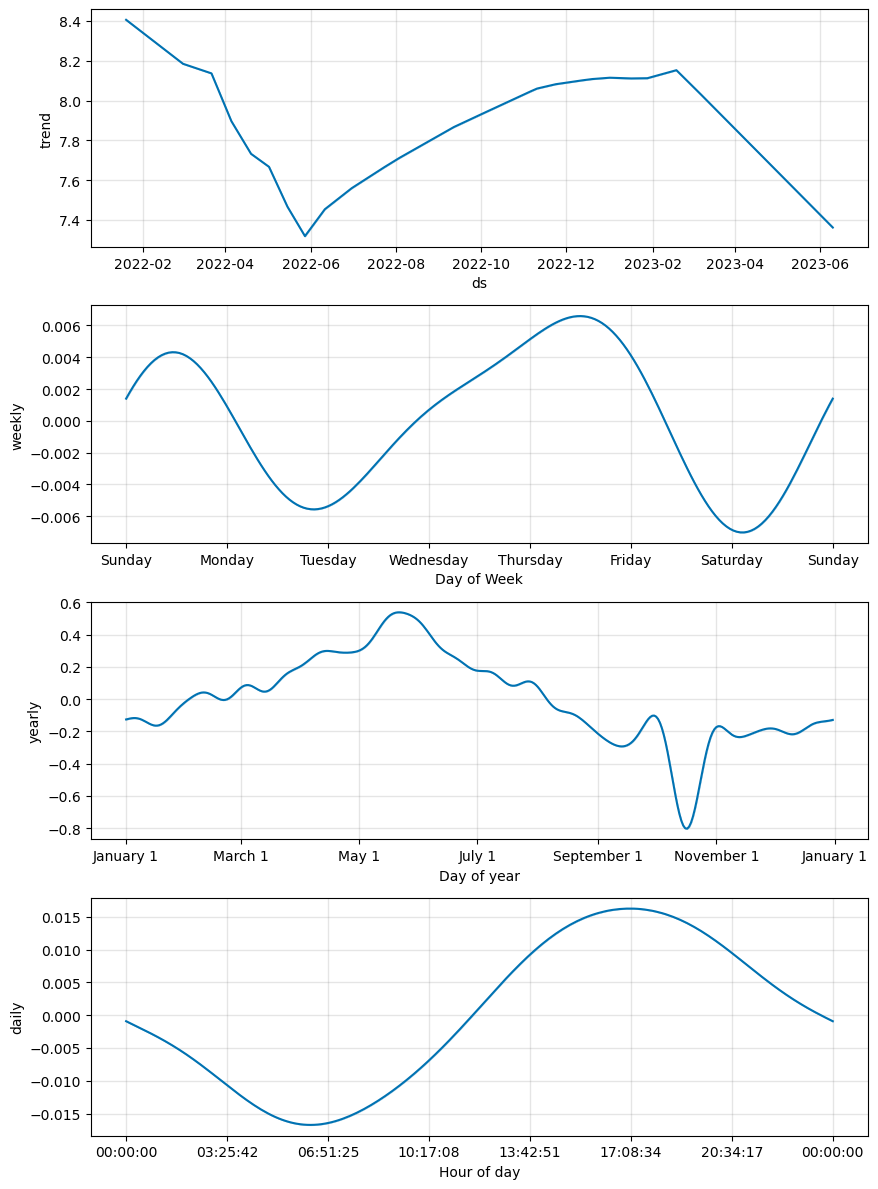

In [314]:
fig = m_hydro720.plot_components(forecast_hydro720)

#### Hydrocat 620

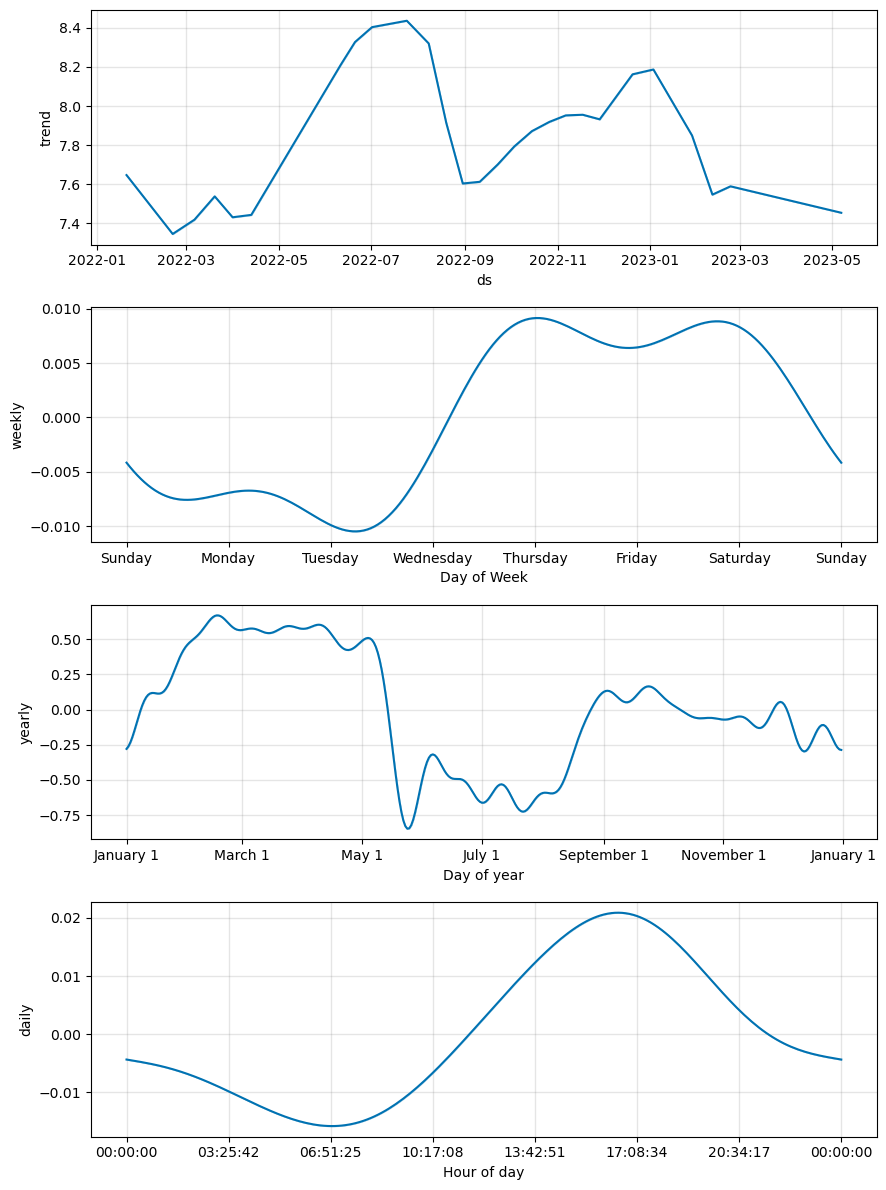

In [315]:
fig = m_hydro620.plot_components(forecast_hydro620)

#### MV
The yearly component doesn't really work for this

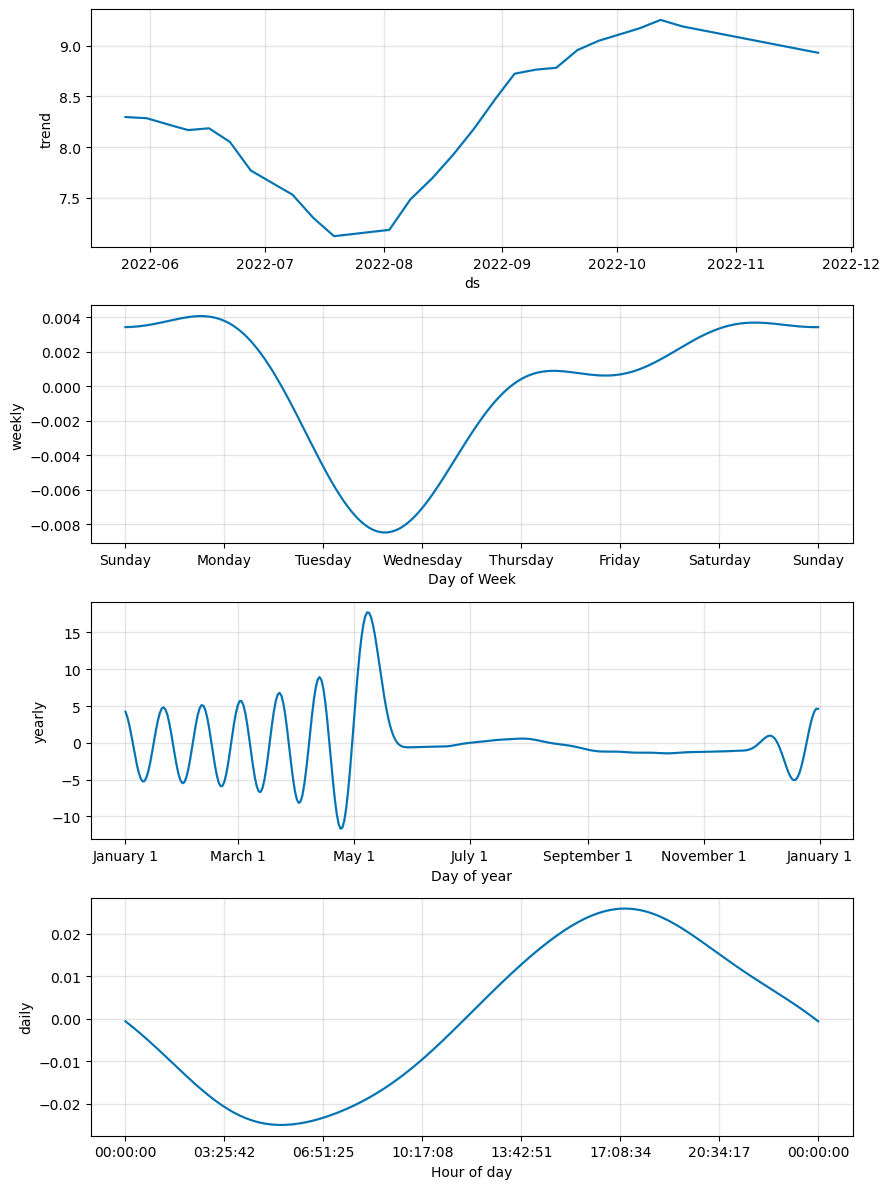

In [316]:
fig = m_mv.plot_components(forecast_mv)

#### QP
Again, the yearly component doesn't really work.

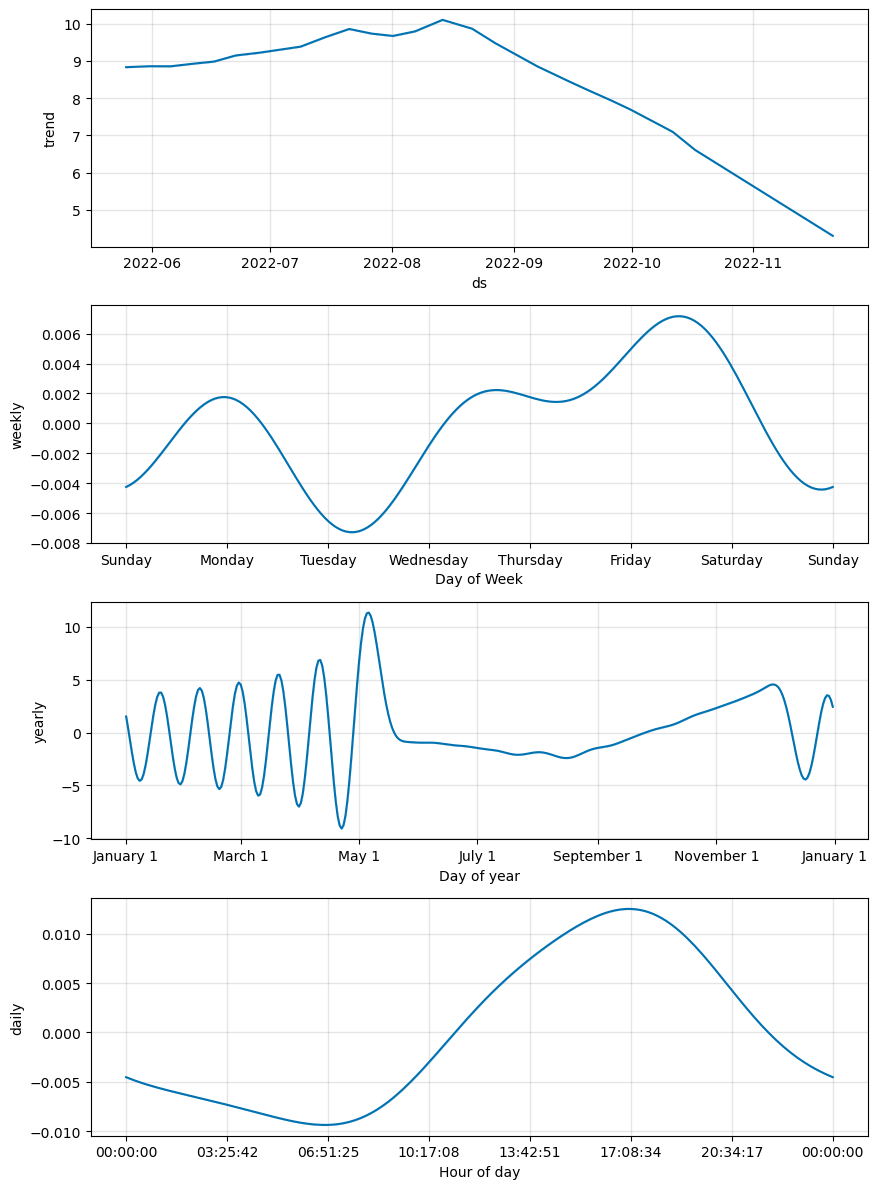

In [317]:
fig = m_qp.plot_components(forecast_qp)

## Plot daily component

I've slightly amended the `plot_seasonality` function to take a color argument. I also commented amount the error bars since that kind of disrupts the legend, given we can't call `label` in this function.

Remember, `ds` is UTC time.

I am unsure what the units of this are. Perhaps the units are arbitrary?

In [318]:
pink = '#ff6289'
purple = '#C79FEF'
blue = '#82e9ff'
green = '#C1F80A'

I think what this does tell is is that there is a clear diurnal cycle, consistent across all the time series. pH increases towards about 5pm UTC time (around noon eastern standard time) and decreases until around 5/6am UTC (midnight-ish eastern standard time). Since the magnitude of the mystery y-axis unit is smaller than, say, the yearly components of the Hydrocats, we can (maybe) surmise that the diurnal signal is much weaker than the annual signal. This aligns with our expectations, since we expect small variations over the course of any one day but much larger variations over the course of 1 year.

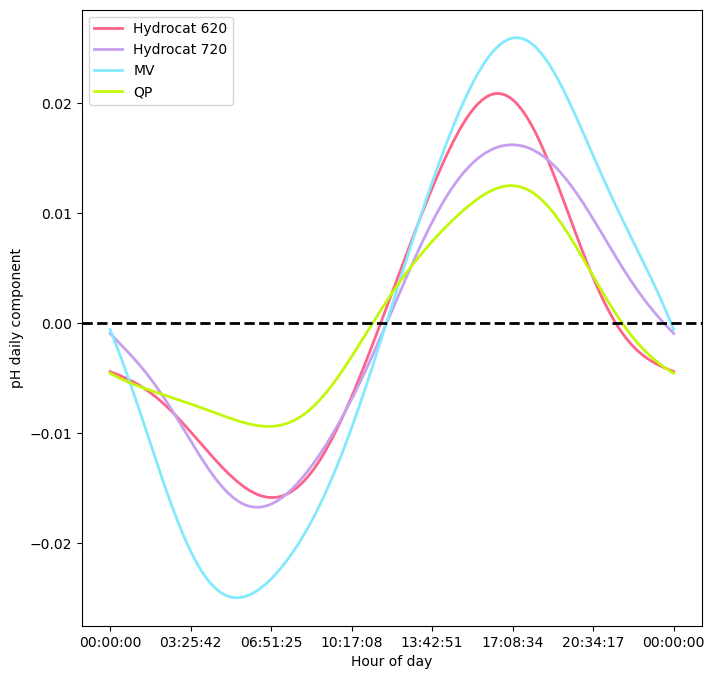

In [319]:
fig, ax = plt.subplots(figsize = [8,8])
plot_seasonality(m_hydro620, 'daily', ax = ax, color = pink)
plot_seasonality(m_hydro720, 'daily', ax = ax, color = purple)
plot_seasonality(m_mv, 'daily', ax = ax, color = blue)
plot_seasonality(m_qp, 'daily', ax = ax, color = green)
ax.legend(['Hydrocat 620', 'Hydrocat 720', 'MV', 'QP'])
ax.set_ylabel('pH daily component')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

# ax2 = ax.twinx()
# plot_seasonality(M, 'daily', ax = ax2, color = 'orange')
# ax2.set_ylabel('∆ Tide Height [m]')

Below I've plotted the yearly component of pH in the hydrocat sensors. They have some *broad* similarities, in that the component is positive in the first part of the year and negative in the second part of the year. Yet they look quite different, which is unexpected because the pH seasonality of 2 bay locations should not be starkly different. Is this signal real? Perhaps, since there could be some actual effects of how in-shore Hydrocat 720 is (i.e. Greenwich Bay). However, I (Abby, I can speak for literally no one else) think this mismatch of signals is not truly real. We have only given Prophet a little over a year of data. To get a robust yearly component, we would need to give it at least a few years. What we can somewhat confidently glean from this, though, is that the yearly component is stronger than the daily component.

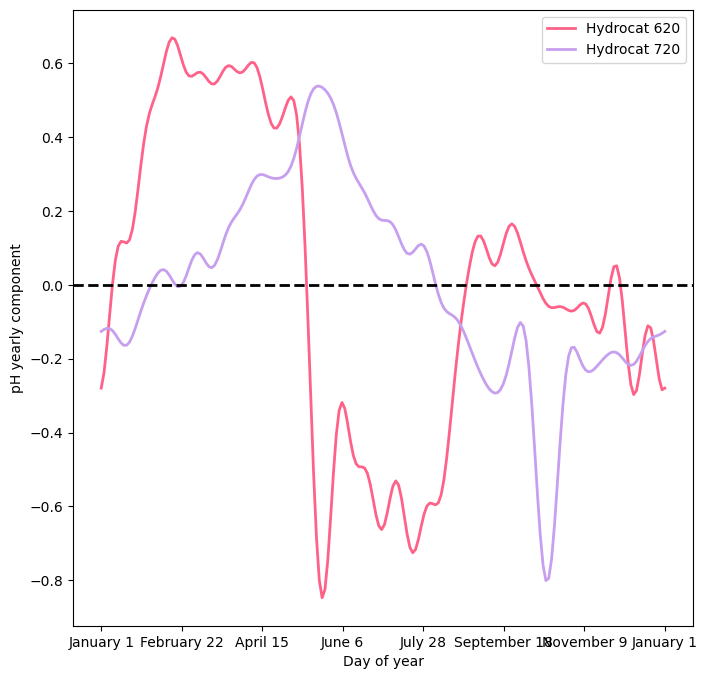

In [320]:
fig, ax = plt.subplots(figsize = [8,8])
plot_seasonality(m_hydro620, 'yearly', ax = ax, color = pink)
plot_seasonality(m_hydro720, 'yearly', ax = ax, color = purple)
# plot_seasonality(m_mv, 'yearly', ax = ax, color = blue)
# plot_seasonality(m_qp, 'yearly', ax = ax, color = green)
ax.legend(['Hydrocat 620', 'Hydrocat 720', 'MV', 'QP'])
ax.set_ylabel('pH yearly component')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

## Specifying Custom Seasonalities

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method.
The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to add_seasonality is the prior scale for that seasonal component - this is discussed below.


17:02:44 - cmdstanpy - INFO - Chain [1] start processing
17:03:18 - cmdstanpy - INFO - Chain [1] done processing


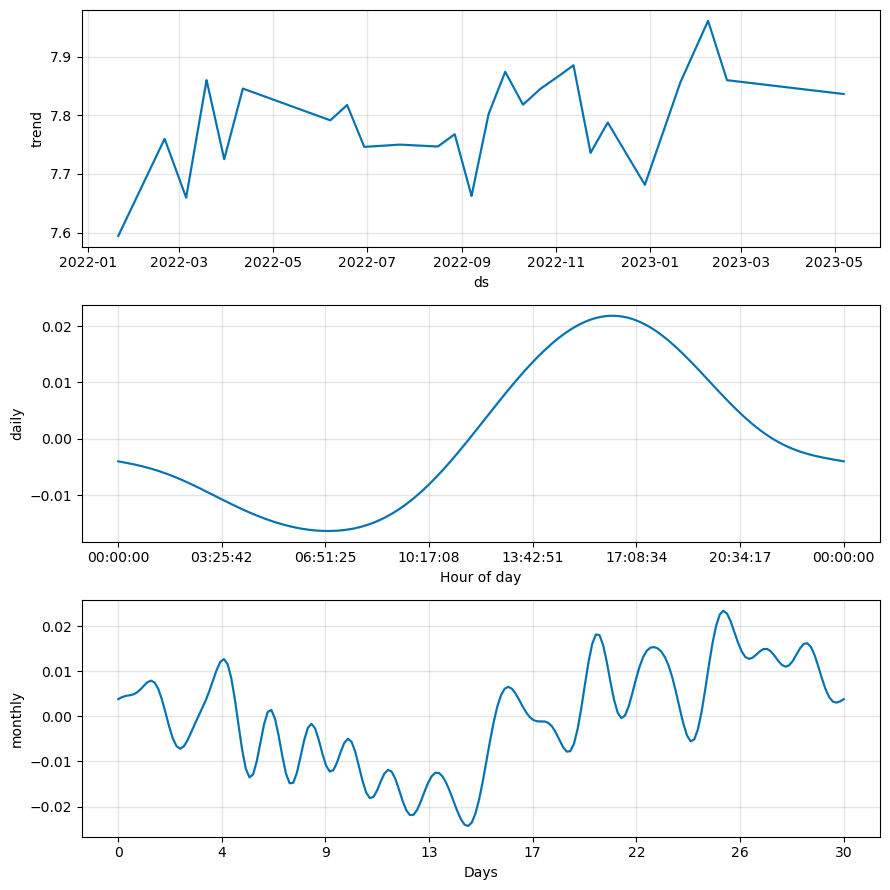

In [270]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=20)
forecast = m.fit(hydro620).predict(future_hydro620)
fig = m.plot_components(forecast)

## Additional regressors

The additional regressors has to be known for both `df` and `future`. To make it known for future, the values of the additional regressor must be known or projected elsewhere. So, let's say we want to add temperature as an additional regressor, we would need to predict tempertare first.

Below I have attempted to add temperature, salinity, and DO as additional regressors to hydrocat 620. Since I am not predicting into the future (I have set period to 0), I do not need to forecast temperature, salinity, or DO. I can simply use the existing data.

In [321]:
# Hydrocat 620
hydro620['temp'] = hydrocat620['hydrocatTemperature']
hydro620['sal'] = hydrocat620['hydrocatSalinity']
hydro620['o2'] = hydrocat620['hydrocatDissOxygen']
m620 = Prophet()
m620.add_regressor('temp')
m620.add_regressor('sal')
m620.add_regressor('o2')
m620.fit(hydro620)

# Hydrocat 720
hydro720['temp'] = hydrocat720['hydrocatTemperature']
hydro720['sal'] = hydrocat720['hydrocatSalinity']
hydro720['o2'] = hydrocat720['hydrocatDissOxygen']
m720 = Prophet()
m720.add_regressor('temp')
m720.add_regressor('sal')
m720.add_regressor('o2')
m720.fit(hydro720)

# MV
mv['temp'] = MV['surface Temp']
mv['sal'] = MV['surface Salinity']
mv['o2'] = MV['surface DO Conc']
mMV = Prophet()
mMV.add_regressor('temp')
mMV.add_regressor('sal')
mMV.add_regressor('o2')
mMV.fit(mv)

# QP
qp['temp'] = QP['surface Temp']
qp['sal'] = QP['surface Salinity']
qp['o2'] = QP['surface DO Conc']
mQP = Prophet()
mQP.add_regressor('temp')
mQP.add_regressor('sal')
mQP.add_regressor('o2')
mQP.fit(qp)


11:05:21 - cmdstanpy - INFO - Chain [1] start processing
11:05:43 - cmdstanpy - INFO - Chain [1] done processing
11:05:45 - cmdstanpy - INFO - Chain [1] start processing
11:06:01 - cmdstanpy - INFO - Chain [1] done processing
11:06:02 - cmdstanpy - INFO - Chain [1] start processing
11:06:09 - cmdstanpy - INFO - Chain [1] done processing
11:06:09 - cmdstanpy - INFO - Chain [1] start processing
11:06:17 - cmdstanpy - INFO - Chain [1] done processing


I have plotted the components below. I have no idea what "trend" is. I don't know the units of `extra_regressors_additive` but I do not the function assumes the extra regressors have an additive effect and what is plotted is the cumulative effect of all of our extra regressors.

In [322]:
FUT620 = m620.make_future_dataframe(periods=0)
FUT620['temp'] = hydrocat620['hydrocatTemperature']
FUT620['sal'] = hydrocat620['hydrocatSalinity']
FUT620['o2'] = hydrocat620['hydrocatDissOxygen']
FORECAST620 = m620.predict(FUT620)

FUT720 = m720.make_future_dataframe(periods=0)
FUT720['temp'] = hydrocat720['hydrocatTemperature']
FUT720['sal'] = hydrocat720['hydrocatSalinity']
FUT720['o2'] = hydrocat720['hydrocatDissOxygen']
FORECAST720 = m720.predict(FUT720)

FUTMV = mMV.make_future_dataframe(periods=0)
FUTMV['temp'] = MV['surface Temp']
FUTMV['sal'] = MV['surface Salinity']
FUTMV['o2'] = MV['surface DO Conc']
FORECASTMV = mMV.predict(FUTMV)

FUTQP = mQP.make_future_dataframe(periods=0)
FUTQP['temp'] = QP['surface Temp']
FUTQP['sal'] = QP['surface Salinity']
FUTQP['o2'] = QP['surface DO Conc']
FORECASTQP = mQP.predict(FUTQP)

I have plotted our additional regressors separately. The results are not *too* surprising. We see positive values of DO regressor in winter when pH is high and negative values of DO regressor when pH is low in summer. This suggests a positive correlation between the two. Temperature is the inverse of this, as high tempertures lower pH and low temperatures correspond with high pH. What is most notable is the effect of salinity is MUCH smaller than temperature and DO.

In [323]:
# Greens
caribbean_green = '#00cc99'
emerald = '#319177'
crayola_green = '#1cac78'
jade = '#00a86b'
kelly = '#4cbb17'
yellowgreen = '#9acd32'

# Blues
french_sky_blue = '#77b5fe'
opal = '#a8c3bc'
baby_blue = '#89cff0'
tiffany_blue = '#0abab5'
cornflower = '#6495ed'

# Pinks
hollywood_cerise = '#f400a1'
baker_miller = '#ff91af'
wild_strawberry = '#ff43a4'

# Purples
iris = '#5a4fcf'
orchid = '#9932cc'
amethyst = '#9966cc'
wisteria = '#c9a0dc'

# Oranges
neon_carrot = '#ffa343'
gamboge = '#e49b0f'
carrot = '#ed9121'

# Yellows
sunglow = '#ffcc33'
bitter_lemon = '#cae00d'
pantone_yellow = '#fedf00'

# Reds
candy_apple = '#e2062c'
carmine = '#eb4c42'
coquelicot = '#ff3800'



Text(0, 0.5, 'Additive regressor')

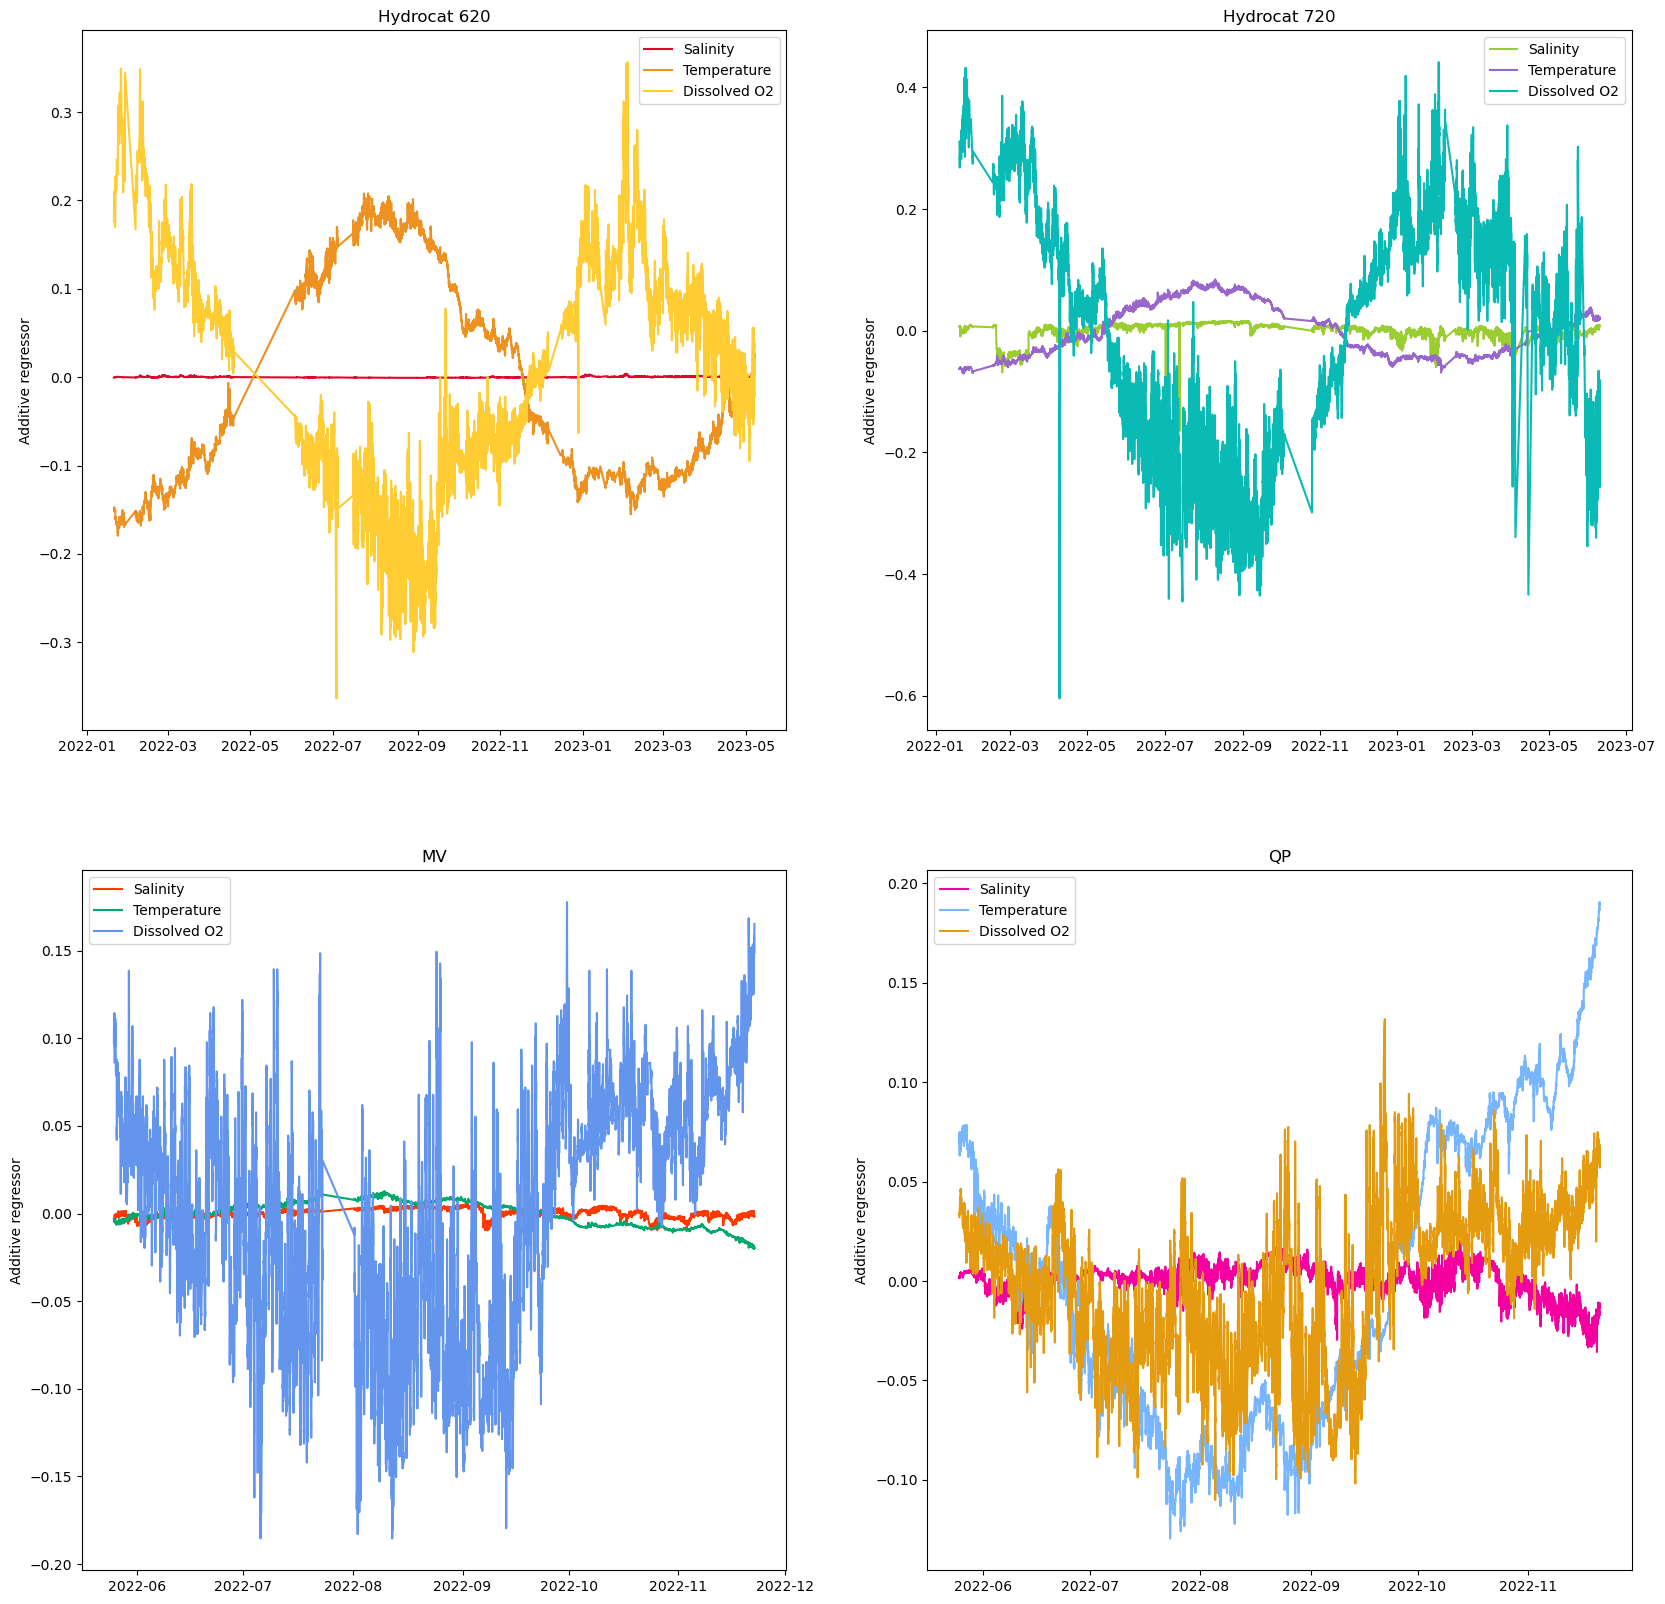

In [324]:
fig, axarr = plt.subplots(nrows = 2, ncols = 2, figsize = [20,20])
axarr = axarr.flatten()

# Hydrocat 620
ax = axarr[0]
ax.plot(FORECAST620['ds'],FORECAST620['sal'], color = candy_apple)
ax.plot(FORECAST620['ds'],FORECAST620['temp'], color = carrot)
ax.plot(FORECAST620['ds'],FORECAST620['o2'], color = sunglow)
ax.legend(['Salinity', 'Temperature', 'Dissolved O2'])
ax.set_title('Hydrocat 620')
ax.set_ylabel('Additive regressor')

# Hydrocat 720
ax = axarr[1]
ax.plot(FORECAST720['ds'],FORECAST720['sal'], color = yellowgreen)
ax.plot(FORECAST720['ds'],FORECAST720['temp'], color = amethyst)
ax.plot(FORECAST720['ds'],FORECAST720['o2'], color = tiffany_blue)
ax.legend(['Salinity', 'Temperature', 'Dissolved O2'])
ax.set_title('Hydrocat 720')
ax.set_ylabel('Additive regressor')

# MV
ax = axarr[2]
ax.plot(FORECASTMV['ds'],FORECASTMV['sal'], color = coquelicot)
ax.plot(FORECASTMV['ds'],FORECASTMV['temp'], color = jade)
ax.plot(FORECASTMV['ds'],FORECASTMV['o2'], color = cornflower)
ax.legend(['Salinity', 'Temperature', 'Dissolved O2'])
ax.set_title('MV')
ax.set_ylabel('Additive regressor')

# QP
ax = axarr[3]
ax.plot(FORECASTQP['ds'],FORECASTQP['sal'], color = hollywood_cerise)
ax.plot(FORECASTQP['ds'],FORECASTQP['temp'], color = french_sky_blue)
ax.plot(FORECASTQP['ds'],FORECASTQP['o2'], color = gamboge)
ax.legend(['Salinity', 'Temperature', 'Dissolved O2'])
ax.set_title('QP')
ax.set_ylabel('Additive regressor')


## Attempting to add tides as an additional regressor

In [150]:
NOAATides = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/NOAA_tides_2022_hourly_MHHW.csv')
NOAATides['DateTime'] = NOAATides['Date'] + ' ' + NOAATides['Time (GMT)']
NOAATides = NOAATides.drop(['Date', 'Time (GMT)'], axis=1)
NOAATides = NOAATides.drop('Preliminary (ft)', axis=1)

for i in NOAATides.keys():
    if i == 'DateTime':
        NOAATides[i] = pd.to_datetime(NOAATides[i])
    else:
        NOAATides[i] = pd.to_numeric(NOAATides[i])

In [152]:
tides_hydro620 = pd.merge_asof(NOAATides, hydrocat620, on="DateTime",tolerance = pd.Timedelta("30m"))

In [174]:
tides_hydro620 = tides_hydro620.dropna()
tides_hydro620 = tides_hydro620.reset_index(drop=True)

In [156]:
tides_hydro620.keys()

Index(['Predicted (ft)', 'Verified (ft)', 'DateTime', 'time', 'ordinal_time',
       'hydrocatTemperature', 'hydrocatDissOxygen', 'hydrocatSalinity',
       'pH total', 'hydrocatFluorescence', 'offset', 'adjusted_ph',
       'offset temp', 'adjusted_ph temp'],
      dtype='object')

10:34:54 - cmdstanpy - INFO - Chain [1] start processing
10:34:57 - cmdstanpy - INFO - Chain [1] done processing


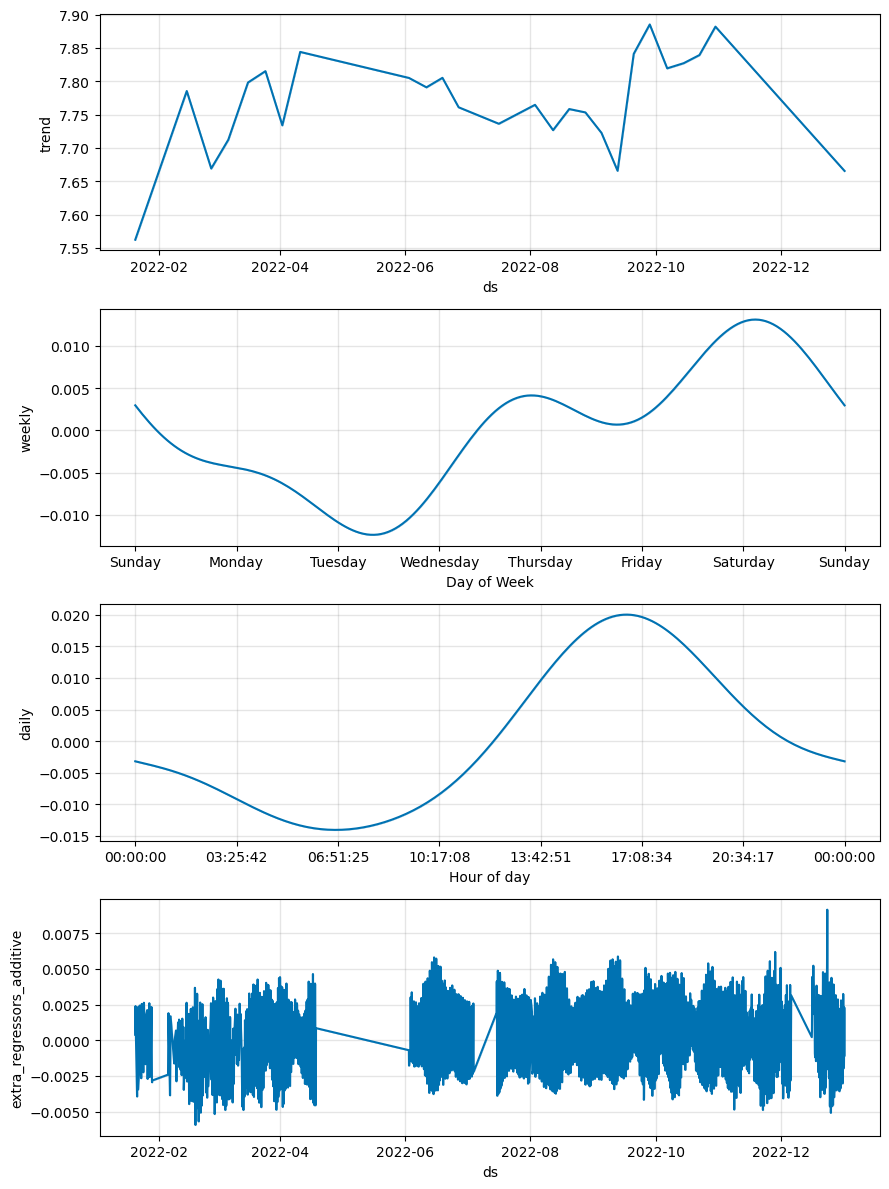

In [175]:
df_tides = tides_hydro620[['DateTime', 'adjusted_ph temp']]
df_tides = df_tides.rename(columns = {'DateTime': 'ds', 'adjusted_ph temp': 'y'})
df_tides['tides'] = tides_hydro620['Verified (ft)']
M = Prophet()
M.add_regressor('tides')
M.fit(df_tides)

FUT = M.make_future_dataframe(periods=0)

FUT['tides'] = tides_hydro620['Verified (ft)']
FORECAST = M.predict(FUT)
fig = M.plot_components(FORECAST)

10:36:39 - cmdstanpy - INFO - Chain [1] start processing
10:36:39 - cmdstanpy - INFO - Chain [1] done processing


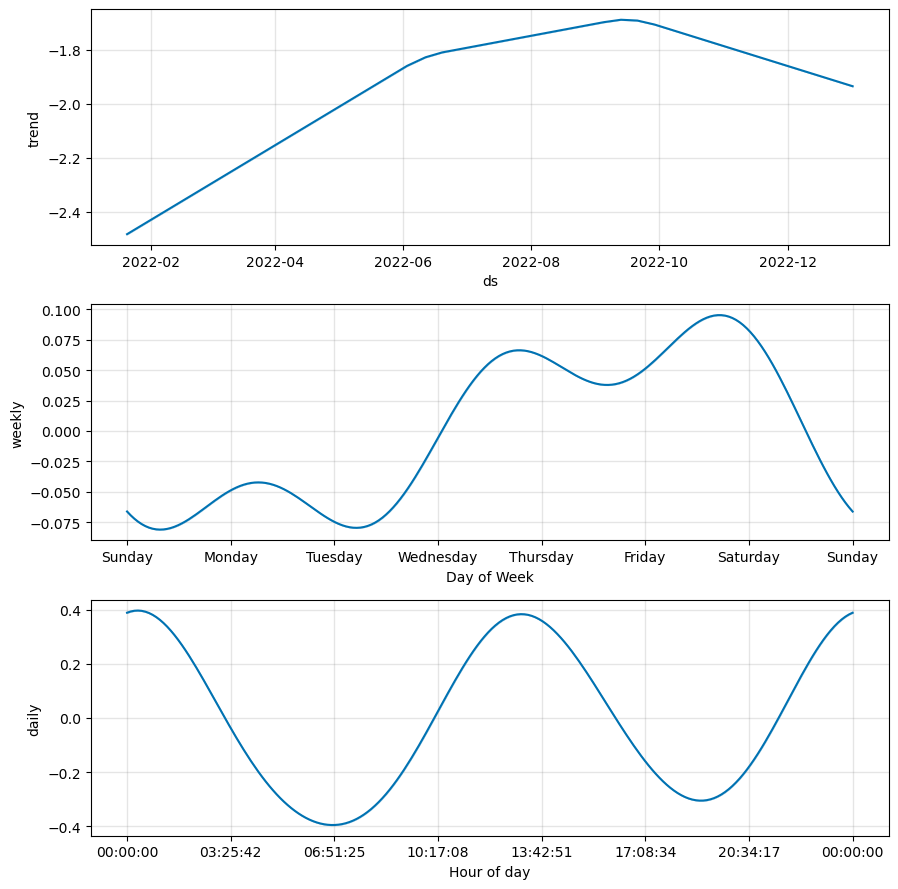

In [177]:
df_tides = tides_hydro620[['DateTime', 'Verified (ft)']]
df_tides = df_tides.rename(columns = {'DateTime': 'ds', 'Verified (ft)': 'y'})
M = Prophet()
M.fit(df_tides)

FUT = M.make_future_dataframe(periods=0)

FORECAST = M.predict(FUT)
fig = M.plot_components(FORECAST)

# Prophet for O2

In [325]:
# Create our data frames for ds and y
hydro720_O2 = hydrocat720[['DateTime', 'hydrocatDissOxygen']]
hydro620_O2 = hydrocat620[['DateTime', 'hydrocatDissOxygen']]
mv_O2 = MV[['DateTime', 'surface DO Conc']]
qp_O2 = QP[['DateTime', 'surface DO Conc']]

# Rename DateTime as ds and pH total as y
hydro620_O2 = hydro620_O2.rename(columns = {'DateTime': 'ds', 'hydrocatDissOxygen': 'y'})
hydro720_O2 = hydro720_O2.rename(columns = {'DateTime': 'ds', 'hydrocatDissOxygen': 'y'})
mv_O2 = mv_O2.rename(columns = {'DateTime': 'ds', 'surface DO Conc': 'y'})
qp_O2 = qp_O2.rename(columns = {'DateTime': 'ds', 'surface DO Conc': 'y'})

# Instatiate Prophet object
mO2_hydro620 = Prophet()
mO2_hydro720 = Prophet()
mO2_mv = Prophet()
mO2_qp = Prophet()

# Add seasonalities
mO2_hydro620.add_seasonality(name='yearly', period=365, fourier_order=20)
mO2_hydro720.add_seasonality(name='yearly', period=365, fourier_order=20)

# Fit Prophet object
mO2_hydro620.fit(hydro620_O2)
mO2_hydro720.fit(hydro720_O2)
mO2_mv.fit(mv_O2)
mO2_qp.fit(qp_O2)

# Make history dataframes for each dataset
future_hydro620_O2 = mO2_hydro620.make_future_dataframe(periods=0)
future_hydro720_O2 = mO2_hydro720.make_future_dataframe(periods=0)
future_mv_O2 = mO2_mv.make_future_dataframe(periods=0)
future_qp_O2 = mO2_qp.make_future_dataframe(periods=0)

# Forecast/predict
forecast_hydro620_O2 = mO2_hydro620.predict(future_hydro620_O2)
forecast_hydro720_O2 = mO2_hydro720.predict(future_hydro720_O2)
forecast_mv_O2 = mO2_mv.predict(future_mv_O2)
forecast_qp_O2 = mO2_qp.predict(future_qp_O2)

11:07:24 - cmdstanpy - INFO - Chain [1] start processing
11:07:57 - cmdstanpy - INFO - Chain [1] done processing
11:08:00 - cmdstanpy - INFO - Chain [1] start processing
11:08:31 - cmdstanpy - INFO - Chain [1] done processing
11:08:32 - cmdstanpy - INFO - Chain [1] start processing
11:08:37 - cmdstanpy - INFO - Chain [1] done processing
11:08:38 - cmdstanpy - INFO - Chain [1] start processing
11:08:43 - cmdstanpy - INFO - Chain [1] done processing


Text(0, 0.5, 'pH daily component')

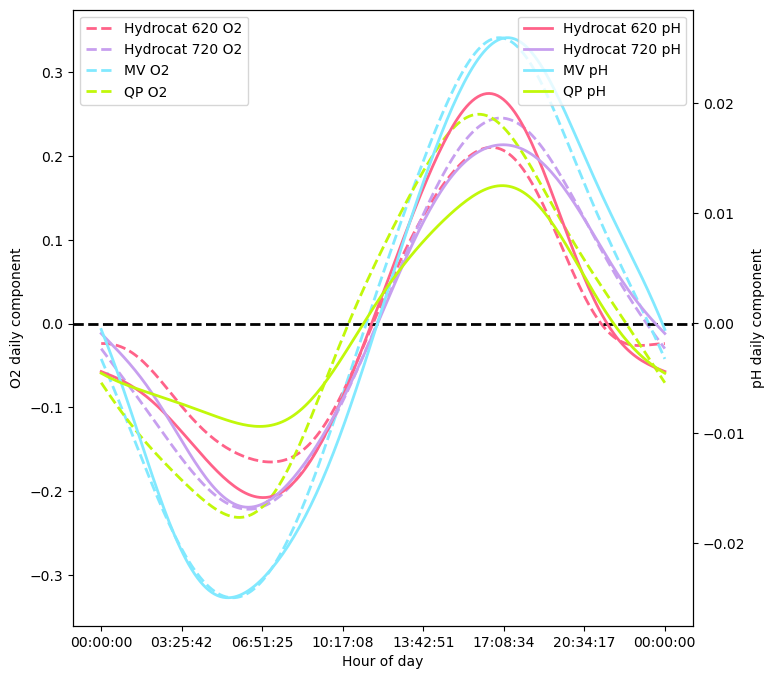

In [326]:
fig, ax = plt.subplots(figsize = [8,8])
plot_seasonality(mO2_hydro620, 'daily', ax = ax, color = pink, line = 'dashed')
plot_seasonality(mO2_hydro720, 'daily', ax = ax, color = purple, line = 'dashed')
plot_seasonality(mO2_mv, 'daily', ax = ax, color = blue, line = 'dashed')
plot_seasonality(mO2_qp, 'daily', ax = ax, color = green, line = 'dashed')
ax.legend(['Hydrocat 620 O2', 'Hydrocat 720 O2', 'MV O2', 'QP O2'])
ax.set_ylabel('O2 daily component')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

ax2 = ax.twinx()
plot_seasonality(m_hydro620, 'daily', ax = ax2, color = pink)
plot_seasonality(m_hydro720, 'daily', ax = ax2, color = purple)
plot_seasonality(m_mv, 'daily', ax = ax2, color = blue)
plot_seasonality(m_qp, 'daily', ax = ax2, color = green)
ax2.legend(['Hydrocat 620 pH', 'Hydrocat 720 pH', 'MV pH', 'QP pH'], loc = 'upper right')
ax2.set_ylabel('pH daily component')

# Prophet for temperature

In [284]:
QP.keys()

Index(['DateTime', 'time', 'ordinal_time', 'surface Temp', 'surface Salinity',
       'surface DO Conc', 'pH total', 'offset', 'adjusted_ph', 'offset temp',
       'adjusted_ph temp'],
      dtype='object')

In [327]:
# Create our data frames for ds and y
hydro720_O2 = hydrocat720[['DateTime', 'hydrocatTemperature']]
hydro620_O2 = hydrocat620[['DateTime', 'hydrocatTemperature']]
mv_O2 = MV[['DateTime', 'surface Temp']]
qp_O2 = QP[['DateTime', 'surface Temp']]

# Rename DateTime as ds and pH total as y
hydro620_O2 = hydro620_O2.rename(columns = {'DateTime': 'ds', 'hydrocatTemperature': 'y'})
hydro720_O2 = hydro720_O2.rename(columns = {'DateTime': 'ds', 'hydrocatTemperature': 'y'})
mv_O2 = mv_O2.rename(columns = {'DateTime': 'ds', 'surface Temp': 'y'})
qp_O2 = qp_O2.rename(columns = {'DateTime': 'ds', 'surface Temp': 'y'})

# Instatiate Prophet object
mO2_hydro620 = Prophet()
mO2_hydro720 = Prophet()
mO2_mv = Prophet()
mO2_qp = Prophet()

# Add seasonalities
mO2_hydro620.add_seasonality(name='yearly', period=365, fourier_order=20)
mO2_hydro720.add_seasonality(name='yearly', period=365, fourier_order=20)

# Fit Prophet object
mO2_hydro620.fit(hydro620_O2)
mO2_hydro720.fit(hydro720_O2)
mO2_mv.fit(mv_O2)
mO2_qp.fit(qp_O2)

# Make history dataframes for each dataset
future_hydro620_O2 = mO2_hydro620.make_future_dataframe(periods=0)
future_hydro720_O2 = mO2_hydro720.make_future_dataframe(periods=0)
future_mv_O2 = mO2_mv.make_future_dataframe(periods=0)
future_qp_O2 = mO2_qp.make_future_dataframe(periods=0)

# Forecast/predict
forecast_hydro620_O2 = mO2_hydro620.predict(future_hydro620_O2)
forecast_hydro720_O2 = mO2_hydro720.predict(future_hydro720_O2)
forecast_mv_O2 = mO2_mv.predict(future_mv_O2)
forecast_qp_O2 = mO2_qp.predict(future_qp_O2)

11:09:11 - cmdstanpy - INFO - Chain [1] start processing
11:09:46 - cmdstanpy - INFO - Chain [1] done processing
11:09:49 - cmdstanpy - INFO - Chain [1] start processing
11:10:18 - cmdstanpy - INFO - Chain [1] done processing
11:10:19 - cmdstanpy - INFO - Chain [1] start processing
11:10:26 - cmdstanpy - INFO - Chain [1] done processing
11:10:26 - cmdstanpy - INFO - Chain [1] start processing
11:10:32 - cmdstanpy - INFO - Chain [1] done processing


Text(0, 0.5, 'pH daily component')

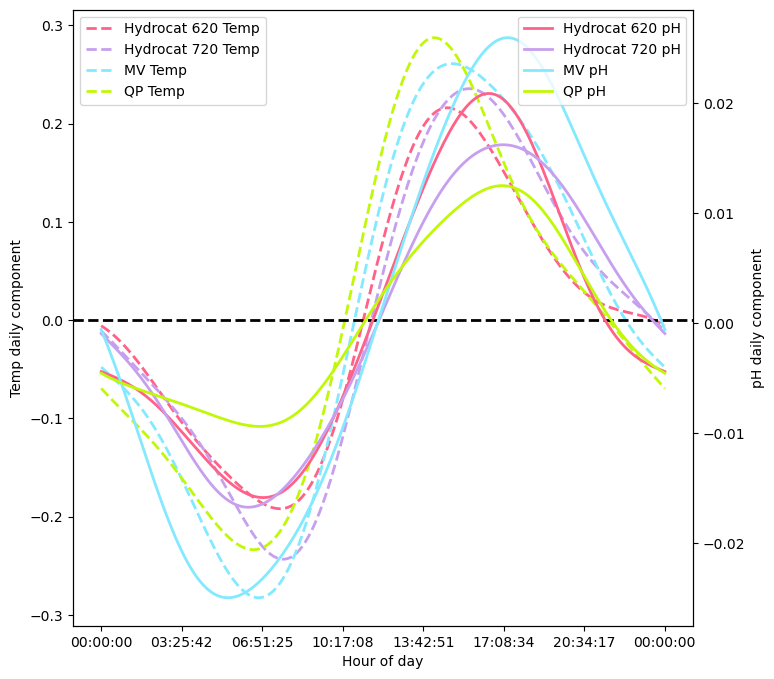

In [328]:
fig, ax = plt.subplots(figsize = [8,8])
plot_seasonality(mO2_hydro620, 'daily', ax = ax, color = pink, line = 'dashed')
plot_seasonality(mO2_hydro720, 'daily', ax = ax, color = purple, line = 'dashed')
plot_seasonality(mO2_mv, 'daily', ax = ax, color = blue, line = 'dashed')
plot_seasonality(mO2_qp, 'daily', ax = ax, color = green, line = 'dashed')
ax.legend(['Hydrocat 620 Temp', 'Hydrocat 720 Temp', 'MV Temp', 'QP Temp'])
ax.set_ylabel('Temp daily component')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

ax2 = ax.twinx()
plot_seasonality(m_hydro620, 'daily', ax = ax2, color = pink)
plot_seasonality(m_hydro720, 'daily', ax = ax2, color = purple)
plot_seasonality(m_mv, 'daily', ax = ax2, color = blue)
plot_seasonality(m_qp, 'daily', ax = ax2, color = green)
ax2.legend(['Hydrocat 620 pH', 'Hydrocat 720 pH', 'MV pH', 'QP pH'], loc = 'upper right')
ax2.set_ylabel('pH daily component')

# Prophet for salinity

In [329]:
# Create our data frames for ds and y
hydro720_O2 = hydrocat720[['DateTime', 'hydrocatSalinity']]
hydro620_O2 = hydrocat620[['DateTime', 'hydrocatSalinity']]
mv_O2 = MV[['DateTime', 'surface Salinity']]
qp_O2 = QP[['DateTime', 'surface Salinity']]

# Rename DateTime as ds and pH total as y
hydro620_O2 = hydro620_O2.rename(columns = {'DateTime': 'ds', 'hydrocatSalinity': 'y'})
hydro720_O2 = hydro720_O2.rename(columns = {'DateTime': 'ds', 'hydrocatSalinity': 'y'})
mv_O2 = mv_O2.rename(columns = {'DateTime': 'ds', 'surface Salinity': 'y'})
qp_O2 = qp_O2.rename(columns = {'DateTime': 'ds', 'surface Salinity': 'y'})

# Instatiate Prophet object
mO2_hydro620 = Prophet()
mO2_hydro720 = Prophet()
mO2_mv = Prophet()
mO2_qp = Prophet()

# Add seasonalities
mO2_hydro620.add_seasonality(name='yearly', period=365, fourier_order=20)
mO2_hydro720.add_seasonality(name='yearly', period=365, fourier_order=20)

# Fit Prophet object
mO2_hydro620.fit(hydro620_O2)
mO2_hydro720.fit(hydro720_O2)
mO2_mv.fit(mv_O2)
mO2_qp.fit(qp_O2)

# Make history dataframes for each dataset
future_hydro620_O2 = mO2_hydro620.make_future_dataframe(periods=0)
future_hydro720_O2 = mO2_hydro720.make_future_dataframe(periods=0)
future_mv_O2 = mO2_mv.make_future_dataframe(periods=0)
future_qp_O2 = mO2_qp.make_future_dataframe(periods=0)

# Forecast/predict
forecast_hydro620_O2 = mO2_hydro620.predict(future_hydro620_O2)
forecast_hydro720_O2 = mO2_hydro720.predict(future_hydro720_O2)
forecast_mv_O2 = mO2_mv.predict(future_mv_O2)
forecast_qp_O2 = mO2_qp.predict(future_qp_O2)

11:10:55 - cmdstanpy - INFO - Chain [1] start processing
11:11:50 - cmdstanpy - INFO - Chain [1] done processing
11:11:53 - cmdstanpy - INFO - Chain [1] start processing
11:12:54 - cmdstanpy - INFO - Chain [1] done processing
11:12:54 - cmdstanpy - INFO - Chain [1] start processing
11:13:03 - cmdstanpy - INFO - Chain [1] done processing
11:13:03 - cmdstanpy - INFO - Chain [1] start processing
11:13:09 - cmdstanpy - INFO - Chain [1] done processing


Text(0, 0.5, 'pH daily component')

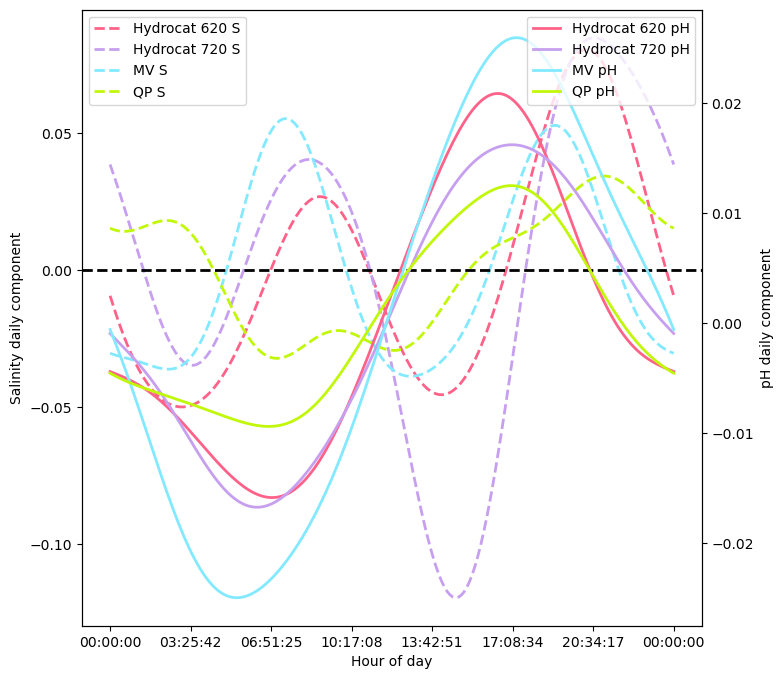

In [330]:
fig, ax = plt.subplots(figsize = [8,8])
plot_seasonality(mO2_hydro620, 'daily', ax = ax, color = pink, line = 'dashed')
plot_seasonality(mO2_hydro720, 'daily', ax = ax, color = purple, line = 'dashed')
plot_seasonality(mO2_mv, 'daily', ax = ax, color = blue, line = 'dashed')
plot_seasonality(mO2_qp, 'daily', ax = ax, color = green, line = 'dashed')
ax.legend(['Hydrocat 620 S', 'Hydrocat 720 S', 'MV S', 'QP S'])
ax.set_ylabel('Salinity daily component')
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)

ax2 = ax.twinx()
plot_seasonality(m_hydro620, 'daily', ax = ax2, color = pink)
plot_seasonality(m_hydro720, 'daily', ax = ax2, color = purple)
plot_seasonality(m_mv, 'daily', ax = ax2, color = blue)
plot_seasonality(m_qp, 'daily', ax = ax2, color = green)
ax2.legend(['Hydrocat 620 pH', 'Hydrocat 720 pH', 'MV pH', 'QP pH'], loc = 'upper right')
ax2.set_ylabel('pH daily component')